In [1]:
import warnings
warnings.filterwarnings('ignore')

import nest_asyncio # It manages running of all coroutines, tasks, callbacks
nest_asyncio.apply() # To avoid RuntimeError: This event loop is already running

import time
import twint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Download at least 100 tweets each for keywords “booster shot” and “covid-19”

In [2]:
def get_tweets(word):
    
    c=twint.Config()
    c.Pandas=True
    c.Search=word
    c.Hide_output=True
    c.Limit=100
    c.Lang="en"

    twint.run.Search(c)
    df = twint.storage.panda.Tweets_df
    return df["tweet"]

In [4]:
tweets = list(get_tweets("booster shot"))[0:100]
tweets.extend(list(get_tweets("covid-19"))[0:100])
len(tweets)

200

In [5]:
df = pd.DataFrame()
df["tweets"] = tweets

my_list = []
my_list.extend(["booster shot"] * 100)
my_list.extend(["covid-19"] * 100)

df["target_class"] = my_list

In [6]:
df.head()

,tweets,target_class
0,As of Monday December 13th anyone in Ontario o...,booster shot
1,There is only one group of people at this time...,booster shot
2,#BoJo houdt een emergency adress to the nation...,booster shot
3,The booster is now available to all adults who...,booster shot
4,@BrokenByWar Wish I waited two weeks for my bo...,booster shot


In [7]:
df.tail()

,tweets,target_class
195,😂😂@DNC @TheDemocrats @LibDems 😂😂 LETS GO BRAN...,covid-19
196,Still unvaccinated and still alive and well. S...,covid-19
197,@lewis_goodall That'd be a tidal wave of #COVI...,covid-19
198,@JudicialWatch From my on line research there ...,covid-19
199,"""I'm feeling good, I'm feeling great!"" Deputy...",covid-19


## Text Pre-processing

In [8]:
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import re 
stop_words = set(stopwords.words('english'))

lemmer = WordNetLemmatizer()

def prep(x):
  
    x = str(x)
    # Lower case
    x = x.lower()
    
    # Remove punctuation
    x = re.sub(r'[^\w\s]', '', x)
    
    # Remove numbers
    x = re.sub(r'\d+', '', x)
     
    # Remove stopwords and lemmatize
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]
    
    return ' '.join(x)

df['clean_tweets'] = df['tweets'].apply(prep)
df.head()

,tweets,target_class,clean_tweets
0,As of Monday December 13th anyone in Ontario o...,booster shot,monday december th anyone ontario book booster...
1,There is only one group of people at this time...,booster shot,one group people time year gathered together f...
2,#BoJo houdt een emergency adress to the nation...,booster shot,bojo houdt een emergency adress nation omicron...
3,The booster is now available to all adults who...,booster shot,booster available adult taken two previous sho...
4,@BrokenByWar Wish I waited two weeks for my bo...,booster shot,brokenbywar wish waited two week booster he ca...


## Vectorization & creating TF-IDF score

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
bow_transformer = CountVectorizer().fit(df["clean_tweets"])
# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

1312


In [11]:
bow = bow_transformer.transform(df["clean_tweets"])
print('Shape of Sparse Matrix: ', bow.shape)
print('Amount of Non-Zero occurences: ', bow.nnz)

Shape of Sparse Matrix:  (200, 1312)
Amount of Non-Zero occurences:  2658


In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow)
tfidf = tfidf_transformer.transform(bow)
print(tfidf.shape)

(200, 1312)


In [13]:
print(tfidf)

  (0, 1222)	0.1790066154157988
  (0, 1143)	0.2997870212816842
  (0, 1044)	0.10602309049940573
  (0, 858)	0.3420477662172866
  (0, 834)	0.3173268151774177
  (0, 767)	0.3420477662172866
  (0, 255)	0.2997870212816842
  (0, 135)	0.3420477662172866
  (0, 134)	0.3420477662172866
  (0, 118)	0.19109097818249643
  (0, 113)	0.2997870212816842
  (0, 43)	0.286182100176045
  (1, 1301)	0.2068414420613475
  (1, 1171)	0.30390049336366326
  (1, 1168)	0.4334354877933278
  (1, 1044)	0.09419874266988076
  (1, 880)	0.30390049336366326
  (1, 859)	0.19125779397219653
  (1, 833)	0.2115548211996534
  (1, 463)	0.28193657498899194
  (1, 428)	0.30390049336366326
  (1, 404)	0.30390049336366326
  (1, 265)	0.24438900852516976
  (1, 246)	0.30390049336366326
  (1, 148)	0.266352926899841
  :	:
  (198, 415)	0.362696724588355
  (198, 356)	0.1813483622941775
  (198, 238)	0.362696724588355
  (198, 220)	0.05300866645581214
  (198, 201)	0.1813483622941775
  (198, 198)	0.362696724588355
  (198, 167)	0.1813483622941775
  (199,

## Dimensionality Reduction
1. Principal Component Analysis (PCA)
2. T-distributed Stochastic Neighbor Embedding (t-SNE)
3. Uniform Manifold Approximation and Projection (UMPA)

### 1. Principal Component Analysis (PCA)

In [14]:
start = time.time()
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components = 2)
X_pca = pca.fit_transform(tfidf)
end_pca = (time.time() - start)
print('Duration: {} seconds'.format(end_pca))

print("\nExplained Variance Ratio:",pca.explained_variance_ratio_)
print("Noise Variance:",round(pca.noise_variance_,3))

Duration: 0.10492491722106934 seconds

Explained Variance Ratio: [0.02011191 0.01364767]
Noise Variance: 0.005


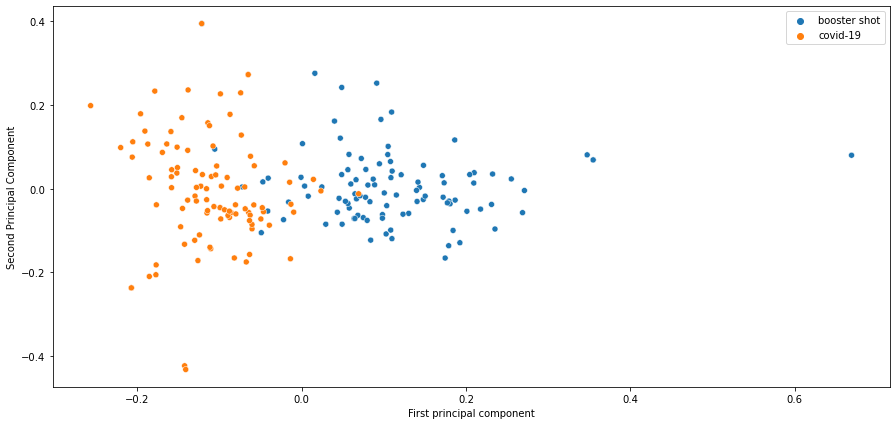

In [15]:
plt.figure(figsize=(15,7))
sns.scatterplot(X_pca[:,0],X_pca[:,1],hue = df["target_class"])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

### 2. T-distributed Stochastic Neighbor Embedding (t-SNE)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.278479
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.946922
[t-SNE] KL divergence after 500 iterations: 0.908224

Duration: 0.4435880184173584 seconds


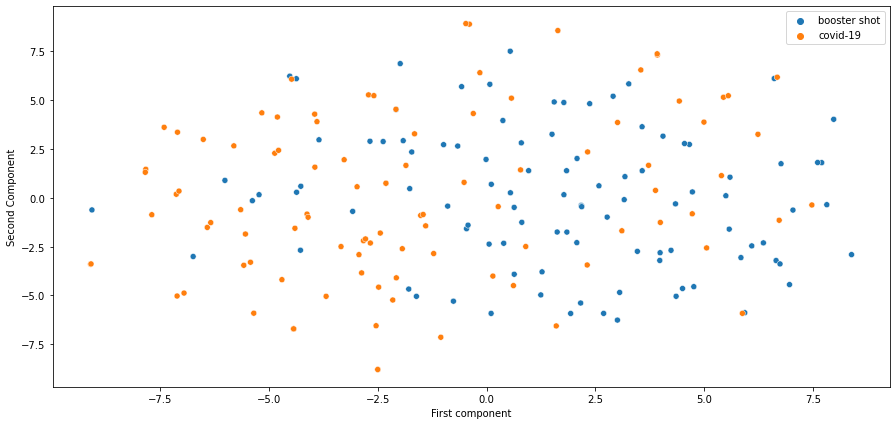

In [16]:
start = time.time()
from sklearn.manifold import TSNE
# With perplexity = 50 and without PCA as pre-processing 
tsne = TSNE(n_components=2, verbose=1, perplexity=50, 
            n_iter=500, random_state=42).fit_transform(tfidf) 

end_tsne_1 = (time.time() - start)
print('\nDuration: {} seconds'.format(end_tsne_1))
# Lower the KL divergence value, the better we have matched the true distribution with our approximation.

plt.figure(figsize=(15,7))
sns.scatterplot(tsne[:,0],tsne[:,1],hue = df["target_class"])
plt.xlabel('First component')
plt.ylabel('Second Component')
plt.legend()
plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.073992
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.110481
[t-SNE] KL divergence after 500 iterations: 0.138429

Duration: 0.4204411506652832 seconds


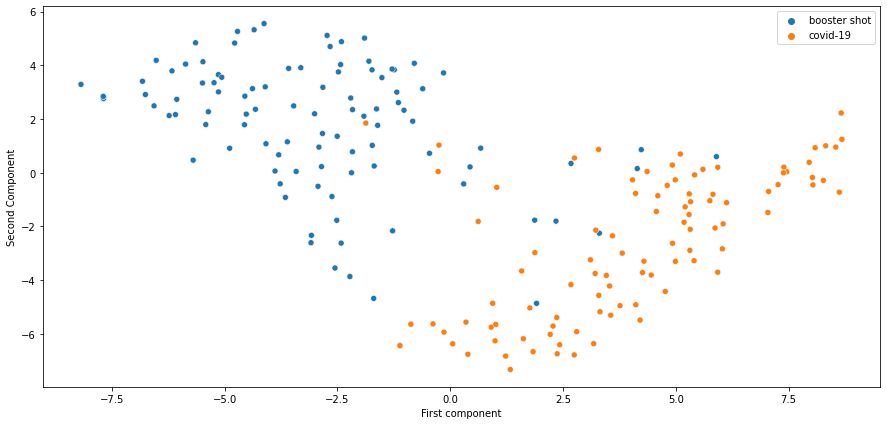

In [17]:
# With perplexity = 50 and PCA as pre-processing 
start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, 
            n_iter=500, random_state=42).fit_transform(X_pca) 

end_tsne_2 = (time.time() - start)
print('\nDuration: {} seconds'.format(end_tsne_2))

# Lower the KL divergence value, the better we have matched the true distribution with our approximation.
# Similar labels are clustered together, even though there are still data points on top of each other

plt.figure(figsize=(15,7))
sns.scatterplot(tsne[:,0],tsne[:,1],hue = df["target_class"])
plt.xlabel('First component')
plt.ylabel('Second Component')
plt.legend()
plt.show()

### 3. Uniform Manifold Approximation and Projection (UMAP)

Init Plugin
Init Graph Optimizer
Init Kernel
UMAP(angular_rp_forest=True, metric='jaccard', n_epochs=500, n_neighbors=30, random_state=42, verbose=1)
Sun Dec 12 23:43:36 2021 Construct fuzzy simplicial set


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sun Dec 12 23:43:36 2021 Finding Nearest Neighbors
Sun Dec 12 23:43:37 2021 Finished Nearest Neighbor Search
Disconnection_distance = 1 has removed 14408 edges.  This is not a problem as no vertices were disconnected.
Sun Dec 12 23:43:38 2021 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Dec 12 23:43:38 2021 Finished embedding

Duration: 5.9584619998931885 seconds


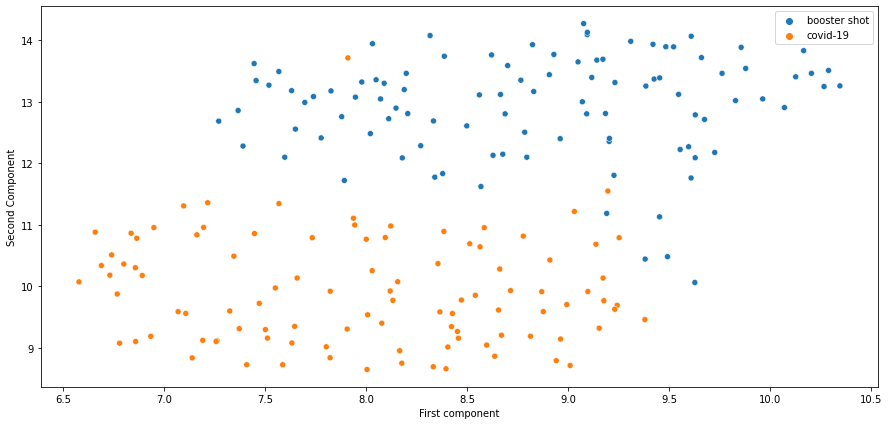

In [18]:
# It can be applied directly to sparse matrices thereby eliminating the need to applying any Dimensionality reduction
# such as PCA or Truncated SVD(Singular Value Decomposition) as a prior pre-processing step.

start = time.time()
import umap
embedding = umap.UMAP(n_neighbors=30, n_components=2, metric='jaccard',
                      n_epochs= 500, verbose=1, random_state=42).fit_transform(tfidf)

end_umap_1 = (time.time() - start)
print('\nDuration: {} seconds'.format(end_umap_1))


plt.figure(figsize=(15,7))
sns.scatterplot(embedding[:,0],embedding[:,1],hue = df["target_class"])
plt.xlabel('First component')
plt.ylabel('Second Component')
plt.legend()
plt.show()

In [ ]:
# Low values of n_neighbours forces UMAP to focus on very local structures 
# while the higher values will make UMAP focus on the larger neighbourhoods.

start = time.time()
import umap
embedding = umap.UMAP(n_neighbors=250, n_components=2, metric='jaccard',
                      n_epochs= 500, verbose=1, random_state=42).fit_transform(tfidf)

end_umap_2 = (time.time() - start)
print('\nDuration: {} seconds'.format(end_umap_2))

plt.figure(figsize=(15,7))
sns.scatterplot(embedding[:,0],embedding[:,1],hue = df["target_class"])
plt.xlabel('First component')
plt.ylabel('Second Component')
plt.legend()
plt.show()

In [ ]:
data = {'DR_Method':['PCA', 'TSNE', 'TSNE_PCA', 'UMAP_30', 'UMAP_250'],
        'Time_Taken':[end_pca, end_tsne_1, end_tsne_2, end_umap_1, end_umap_2]}

df_time = pd.DataFrame(data)
df_time.sort_values(by = "Time_Taken", ignore_index=True)